# Decision tree model

## Assessing the predictive ability of a decision tree model
Using a training and testing split of the DCD and DBD datasets to fit and assess the predictive ability of a decision tree model

In [1]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
import sklearn.metrics as mets
%matplotlib inline

In [2]:
#Read in dataset with all rows included
df = pd.read_sas("Data/alldata3.sas7bdat")

#6931 DBD apps
dbd_apps = df[(df["eli_DBD"]==1)&(df["FAMILY_APPROACHED"]==2)]

#6060 DBD apps to match cohort in paper
dbd_apps = dbd_apps[(dbd_apps["eth_grp"]!=5)&(dbd_apps["FORMAL_APR_WHEN"]!=4)&(dbd_apps["donation_mentioned"]!=-1)
                    &(dbd_apps["FAMILY_WITNESS_BSDT"]!=9)&(dbd_apps["GENDER"]!=9)]
     
#9965 DCD apps
dcd_apps = df[(df["eli_DCD"]==1)&(df["FAMILY_APPROACHED"]==2)]

#9405 DCD apps to match cohort in paper
dcd_apps = dcd_apps[(dcd_apps["GENDER"]!=9)&(dcd_apps["cod_neuro"].notna())&(dcd_apps["eth_grp"]!=5)&(dcd_apps["donation_mentioned"]!=-1)&
                    (~dcd_apps["DTC_WD_TRTMENT_PRESENT"].isin([8,9]))]

# Columns used to create DBD model in paper
dbd_cols = ["wish", "FORMAL_APR_WHEN", "donation_mentioned", "app_nature", "eth_grp", "religion_grp", "GENDER", "FAMILY_WITNESS_BSDT", "DTC_PRESENT_BSD_CONV", 
            "acorn_new", "adult","FAMILY_CONSENT"]

dbd_apps[dbd_cols].astype(int)

dbd_model_data = dbd_apps[dbd_cols]
dbd_model_data2 = pd.get_dummies(data=dbd_model_data,columns=dbd_cols[:-1],drop_first=True)

dbd_features = dbd_model_data2.drop("FAMILY_CONSENT",axis=1)
dbd_consents = dbd_model_data2["FAMILY_CONSENT"]

# Columns used to create DCD model in paper
dcd_cols = ["wish", "donation_mentioned", 
            "app_nature", "eth_grp", "religion_grp", "GENDER", "DTC_WD_TRTMENT_PRESENT", 
            "acorn_new", "adult","cod_neuro","FAMILY_CONSENT"]

dcd_apps[dbd_cols].astype(int)

dcd_model_data = dcd_apps[dcd_cols]
dcd_model_data2 = pd.get_dummies(data=dcd_model_data,columns=dcd_cols[:-1],drop_first=True)

dcd_features = dcd_model_data2.drop("FAMILY_CONSENT",axis=1)
dcd_consents = dcd_model_data2["FAMILY_CONSENT"]

# creating a train and testing dataset for DBD and DCD approaches

# 1382 consents, 618 non-consents in test data
DBD_X_train, DBD_X_test, DBD_y_train, DBD_y_test = train_test_split(dbd_features,dbd_consents, test_size=0.33, random_state=10)

# 1865 consents, 1239 non-consents in t
DCD_X_train, DCD_X_test, DCD_y_train, DCD_y_test = train_test_split(dcd_features,dcd_consents, test_size=0.33, random_state=10)

In [4]:
# create a tree model with defaut hyperparameters
tree_model = DecisionTreeClassifier(max_depth=10)

In [5]:
# fit tree using dbd training data
DBD_tree = tree_model.fit(DBD_X_train,DBD_y_train)

DBD_preds = DBD_tree.predict(DBD_X_test)

dbd_cm = mets.confusion_matrix(DBD_y_test, DBD_preds)


# output confusion matrix, classification report and balanced accuracy
print("TN  FN\nFP  TP\n")
print(str(int(dbd_cm[0,0])) + "    " + str(int(dbd_cm[0,1])))
print(str(int(dbd_cm[1,0])) + "    " + str(int(dbd_cm[1,1])) + "\n") 

# classification report for DBD model
print(mets.classification_report(DBD_y_test, DBD_preds))

print("Balanced accuracy: " + str(round(mets.balanced_accuracy_score(DBD_y_test, DBD_preds),2)))

print("Accuracy: " + str(round(mets.accuracy_score(DBD_y_test, DBD_preds),2)))

TN  FN
FP  TP

188    430
90    1292

              precision    recall  f1-score   support

         1.0       0.68      0.30      0.42       618
         2.0       0.75      0.93      0.83      1382

    accuracy                           0.74      2000
   macro avg       0.71      0.62      0.63      2000
weighted avg       0.73      0.74      0.70      2000

Balanced accuracy: 0.62
Accuracy: 0.74


In [6]:
# repeat above for DCD data
DCD_tree = tree_model.fit(DCD_X_train,DCD_y_train)

DCD_preds = DCD_tree.predict(DCD_X_test)

dcd_cm = mets.confusion_matrix(DCD_y_test, DCD_preds)

print("TN  FN\nFP  TP\n")
print(str(int(dcd_cm[0,0])) + "    " + str(int(dcd_cm[0,1])))
print(str(int(dcd_cm[1,0])) + "    " + str(int(dcd_cm[1,1])) + "\n") 

# classification report for DCD model
print(mets.classification_report(DCD_y_test, DCD_preds))

print("Balanced accuracy: " + str(round(mets.balanced_accuracy_score(DCD_y_test, DCD_preds),2)))

print("Accuracy: " + str(round(mets.accuracy_score(DCD_y_test, DCD_preds),2)))

TN  FN
FP  TP

768    471
437    1428

              precision    recall  f1-score   support

         1.0       0.64      0.62      0.63      1239
         2.0       0.75      0.77      0.76      1865

    accuracy                           0.71      3104
   macro avg       0.69      0.69      0.69      3104
weighted avg       0.71      0.71      0.71      3104

Balanced accuracy: 0.69
Accuracy: 0.71


## Tuning decision tree

In [7]:
# Loop through tree depths between 1 and 200 and create lists of recall and balanced accuracy 
depths = np.linspace(start=1,stop=200,num=200)
recall_cons = []
recall_refs = []
bas = []

for d in depths:
    tree_model = DecisionTreeClassifier(max_depth=d,random_state=66)
    DBD_tree = tree_model.fit(DBD_X_train,DBD_y_train)
    DBD_preds = DBD_tree.predict(DBD_X_test)
    recall_cons.append(mets.recall_score(DBD_y_test,DBD_preds,pos_label=2))
    recall_refs.append(mets.recall_score(DBD_y_test,DBD_preds,pos_label=1))
    bas.append(mets.balanced_accuracy_score(DBD_y_test,DBD_preds))  

# prunt max recall for non consent group and average balanced accuracy for depths above 31
print(depths[np.argmax(recall_refs)])
print(np.mean(bas[30:]))

25.0
0.6385333389534421


Text(0.5, 0, 'Maximum tree depth')

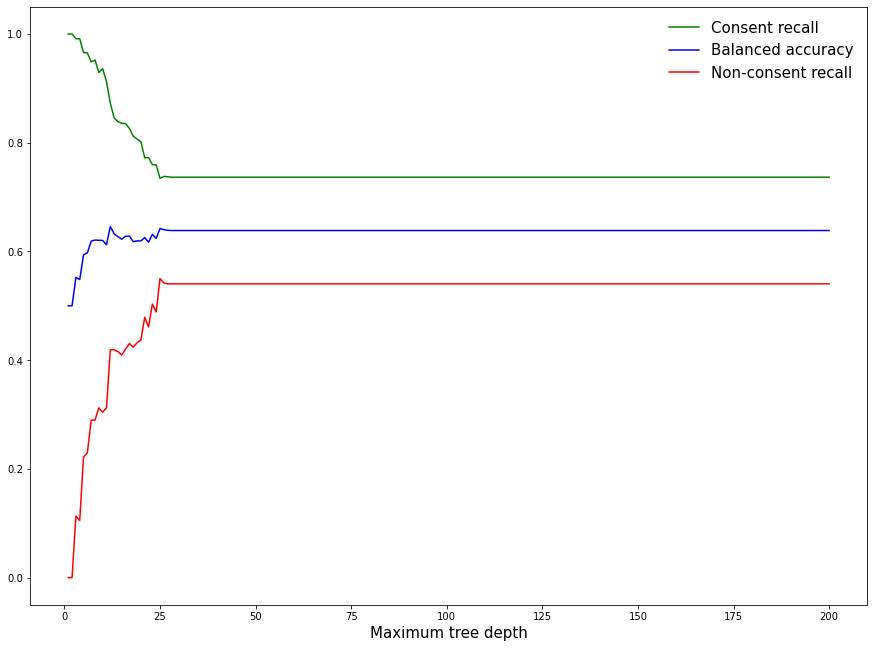

In [48]:
# plot recall for each class and balanced accuracy against tree depth
fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

ax.plot(depths,recall_cons, 'g-')
ax.plot(depths,bas,'b-')
ax.plot(depths,recall_refs,'r-')

ax.legend(["Consent recall","Balanced accuracy", "Non-consent recall"],loc=1,fontsize=15,frameon=False)

plt.xlabel("Maximum tree depth", fontsize=15)

In [211]:
# Loop through tree depths between 1 and 200 and create lists of recall and balanced accuracy  
min_split = np.arange(start=2,stop=200,step=10)
recall_cons = []
recall_refs = []
bas = []

for n in min_split:
    tree_model = DecisionTreeClassifier(max_depth=27,min_samples_split=n,random_state=66)
    DBD_tree = tree_model.fit(DBD_X_train,DBD_y_train)
    DBD_preds = DBD_tree.predict(DBD_X_test)
    recall_cons.append(mets.recall_score(DBD_y_test,DBD_preds,pos_label=2))
    recall_refs.append(mets.recall_score(DBD_y_test,DBD_preds,pos_label=1))
    bas.append(mets.balanced_accuracy_score(DBD_y_test,DBD_preds))

# print the minimum split where balanced accuracy is highest
print(min_split[np.argmax(bas)])

82


Text(0.5, 0, 'Minimum samples for a split')

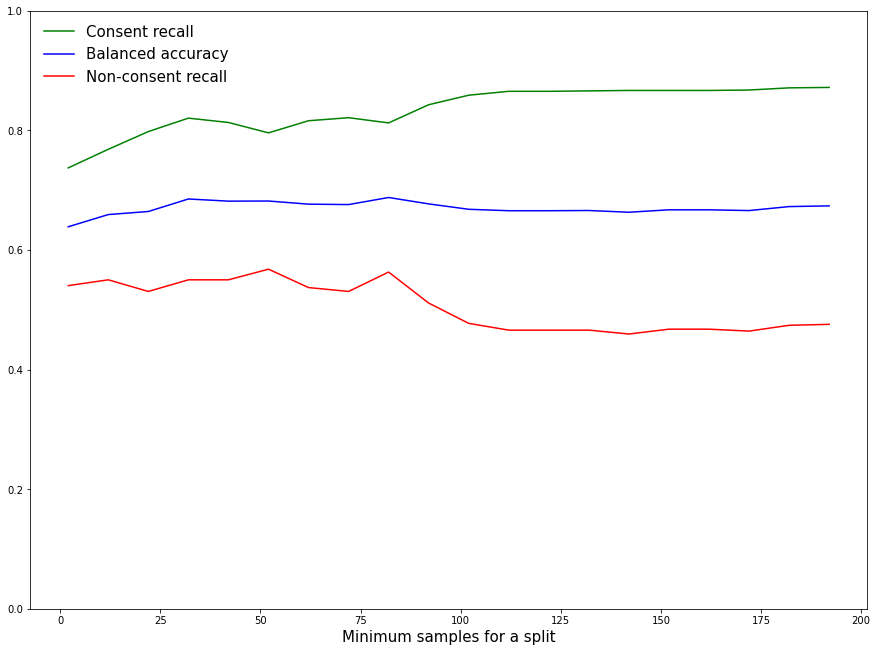

In [212]:
# plot metrics against minimum samples for a split
fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

ax.plot(min_split,recall_cons, 'g-')
ax.plot(min_split,bas,'b-')
ax.plot(min_split,recall_refs,'r-')
ax.set_ylim(0,1)

ax.legend(["Consent recall","Balanced accuracy", "Non-consent recall"],loc=2,fontsize=15,frameon=False)

plt.xlabel("Minimum samples for a split", fontsize=15)

In [209]:
# loop through minimum leaf sizes from 1 to 50 and output metrics to lists
min_leaf = np.arange(start=1,stop=50,step=5)
recall_cons = []
recall_refs = []
bas = []

for n in min_leaf:
    tree_model = DecisionTreeClassifier(max_depth=27,min_samples_leaf=n,random_state=66)
    DBD_tree = tree_model.fit(DBD_X_train,DBD_y_train)
    DBD_preds = DBD_tree.predict(DBD_X_test)
    recall_cons.append(mets.recall_score(DBD_y_test,DBD_preds,pos_label=2))
    recall_refs.append(mets.recall_score(DBD_y_test,DBD_preds,pos_label=1))
    bas.append(mets.balanced_accuracy_score(DBD_y_test,DBD_preds))

# print minimum leaf size with highest non-consent recall    
print(min_leaf[np.argmax(recall_refs)])

1


Text(0.5, 0, 'Minimum samples for a leaf')

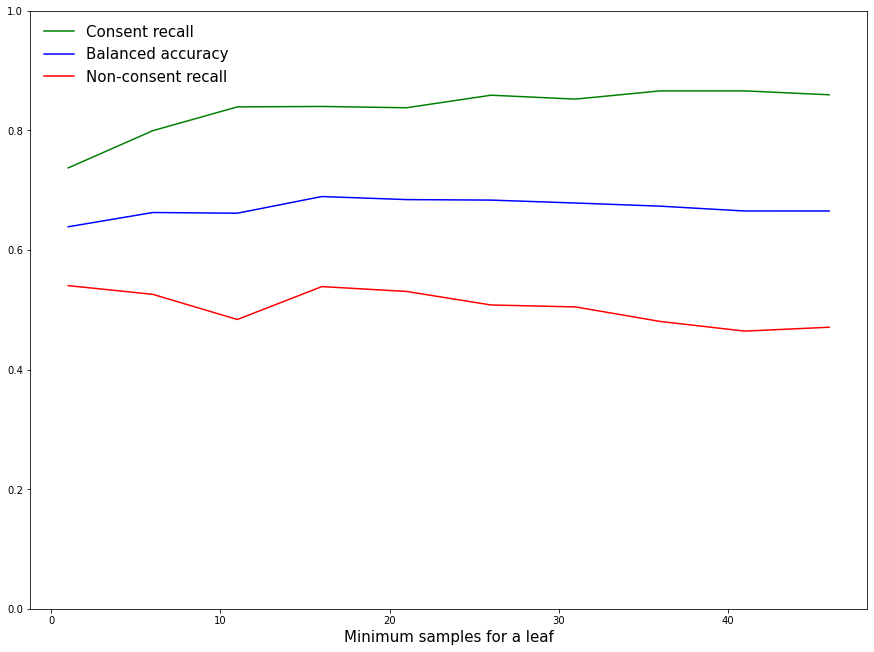

In [210]:
# plot metrics against minimum samples for leaf
fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

ax.plot(min_leaf,recall_cons, 'g-')
ax.plot(min_leaf,bas,'b-')
ax.plot(min_leaf,recall_refs,'r-')
ax.set_ylim(0,1)

ax.legend(["Consent recall","Balanced accuracy", "Non-consent recall"],loc=2,fontsize=15,frameon=False)

plt.xlabel("Minimum samples for a leaf", fontsize=15)

In [153]:
# loop through non-consent weightings from 1 to 5 by 0.1
nc_weight = np.arange(start=1,stop=5,step=0.1)
recall_cons = []
recall_refs = []
bas = []

for n in nc_weight:
    weights = {1.0:n,2.0:1}
    tree_model = DecisionTreeClassifier(max_depth=27,min_samples_split=2,class_weight=weights,random_state=66)
    DBD_tree = tree_model.fit(DBD_X_train,DBD_y_train)
    DBD_preds = DBD_tree.predict(DBD_X_test)
    recall_cons.append(mets.recall_score(DBD_y_test,DBD_preds,pos_label=2))
    recall_refs.append(mets.recall_score(DBD_y_test,DBD_preds,pos_label=1))
    bas.append(mets.balanced_accuracy_score(DBD_y_test,DBD_preds))

# print non-consent weight with highest balanced accuracy
print(nc_weight[np.argmax(bas)])

2.7000000000000015


Text(0.5, 0, 'Weighting to non-consent group')

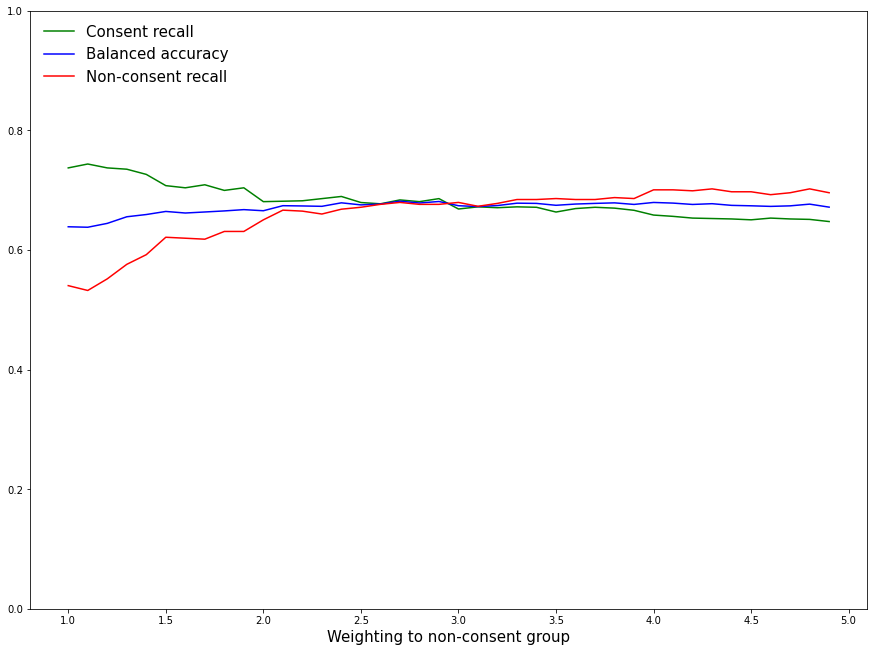

In [151]:
# plot metrics against non-consent weight 
fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.set_facecolor("white")

ax.plot(nc_weight,recall_cons, 'g-')
ax.plot(nc_weight,bas,'b-')
ax.plot(nc_weight,recall_refs,'r-')
ax.set_ylim(0,1)

ax.legend(["Consent recall","Balanced accuracy", "Non-consent recall"],loc=2,fontsize=15,frameon=False)

plt.xlabel("Weighting to non-consent group", fontsize=15)

## Tree model with each setting at optimal found above

In [9]:
tree_model = DecisionTreeClassifier(max_depth=27,min_samples_split=82,random_state=66)

In [10]:
DBD_tree = tree_model.fit(DBD_X_train,DBD_y_train)

DBD_preds = DBD_tree.predict(DBD_X_test)

dbd_cm = mets.confusion_matrix(DBD_y_test, DBD_preds)

print("TN  FN\nFP  TP\n")
print(str(int(dbd_cm[0,0])) + "    " + str(int(dbd_cm[0,1])))
print(str(int(dbd_cm[1,0])) + "    " + str(int(dbd_cm[1,1])) + "\n") 

# classification report for DBD model
print(mets.classification_report(DBD_y_test, DBD_preds))

print("Balanced accuracy: " + str(round(mets.balanced_accuracy_score(DBD_y_test, DBD_preds),2)))

print("Accuracy: " + str(round(mets.accuracy_score(DBD_y_test, DBD_preds),2)))

TN  FN
FP  TP

348    270
259    1123

              precision    recall  f1-score   support

         1.0       0.57      0.56      0.57       618
         2.0       0.81      0.81      0.81      1382

    accuracy                           0.74      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.73      0.74      0.73      2000

Balanced accuracy: 0.69
Accuracy: 0.74


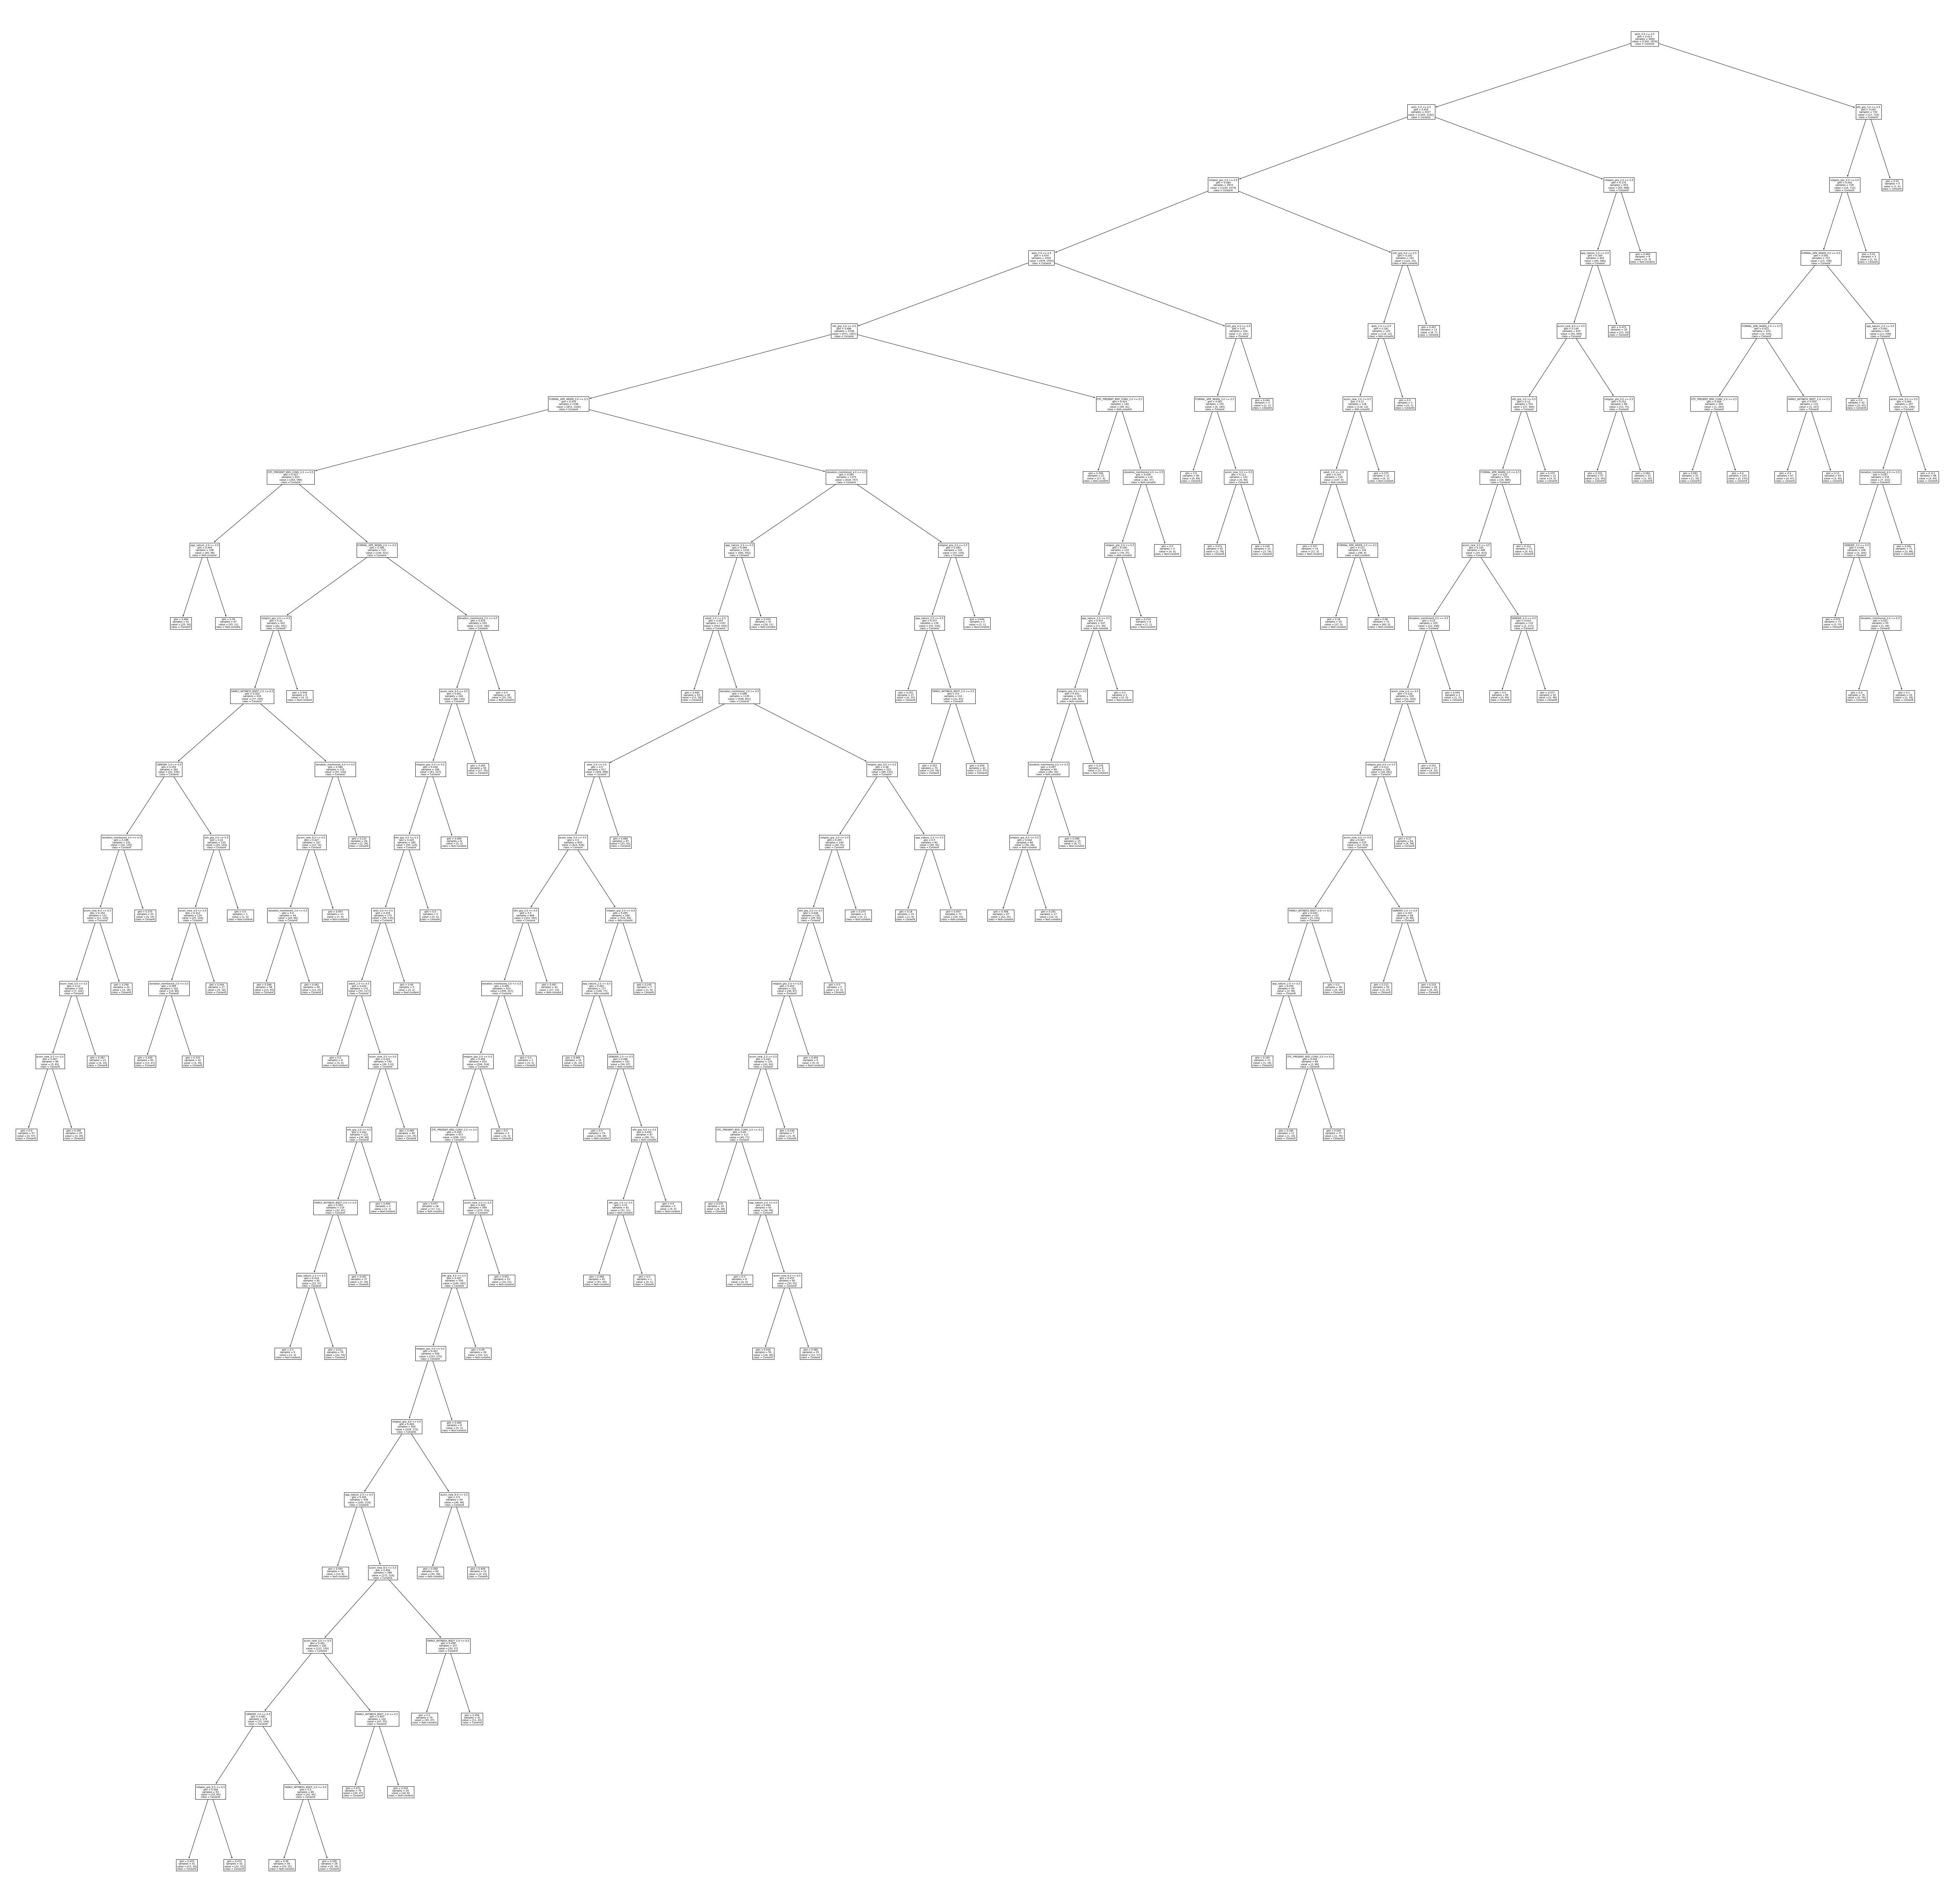

In [11]:
# Plot tree
fig,ax = plt.subplots(1,1,figsize=[100,100])
plot_tree(DBD_tree,feature_names=dbd_features.columns,class_names=["Non-consent","Consent"])
plt.show()

## Cross validated grid search hyperparameter tuning

In [3]:
# create tree model 
tree_model = DecisionTreeClassifier(random_state=66)

# create list of dictionaries with non-consent group weights
weights = []
for w in np.arange(1,4,step=0.25):
    w_dic = {1.0:w,2.0:1}
    weights.append(w_dic)

# use dictionary of parameters in a CV grid search to find tree which optimises balanced accuracy 
params = {'max_depth':np.arange(10,35,step=1),'min_samples_split':np.arange(75,250,step=25),'class_weight':weights}

gs_tree_model = GridSearchCV(tree_model, param_grid=params, scoring="balanced_accuracy",cv=5)

gs_tree_model.fit(DBD_X_train,DBD_y_train)

gs_tree_model.score(DBD_X_train,DBD_y_train)


# print hyperparameter which optimise balanced accuracy and the balanced accuracy
print(gs_tree_model.best_params_)

print(gs_tree_model.best_score_)

{'class_weight': {1.0: 2.25, 2.0: 1}, 'max_depth': 17, 'min_samples_split': 225}
0.7449333105183623


In [51]:
DBD_preds = gs_tree_model.predict(DBD_X_test)

dbd_cm = mets.confusion_matrix(DBD_y_test, DBD_preds)

print("TN  FN\nFP  TP\n")
print(str(int(dbd_cm[0,0])) + "    " + str(int(dbd_cm[0,1])))
print(str(int(dbd_cm[1,0])) + "    " + str(int(dbd_cm[1,1])) + "\n") 

# classification report for DBD model
print(mets.classification_report(DBD_y_test, DBD_preds))

print("Balanced accuracy: " + str(round(mets.balanced_accuracy_score(DBD_y_test, DBD_preds),2)))

print("Accuracy: " + str(round(mets.accuracy_score(DBD_y_test, DBD_preds),2)))

TN  FN
FP  TP

523    95
480    902

              precision    recall  f1-score   support

         1.0       0.52      0.85      0.65       618
         2.0       0.90      0.65      0.76      1382

    accuracy                           0.71      2000
   macro avg       0.71      0.75      0.70      2000
weighted avg       0.79      0.71      0.72      2000

Balanced accuracy: 0.75
Accuracy: 0.71


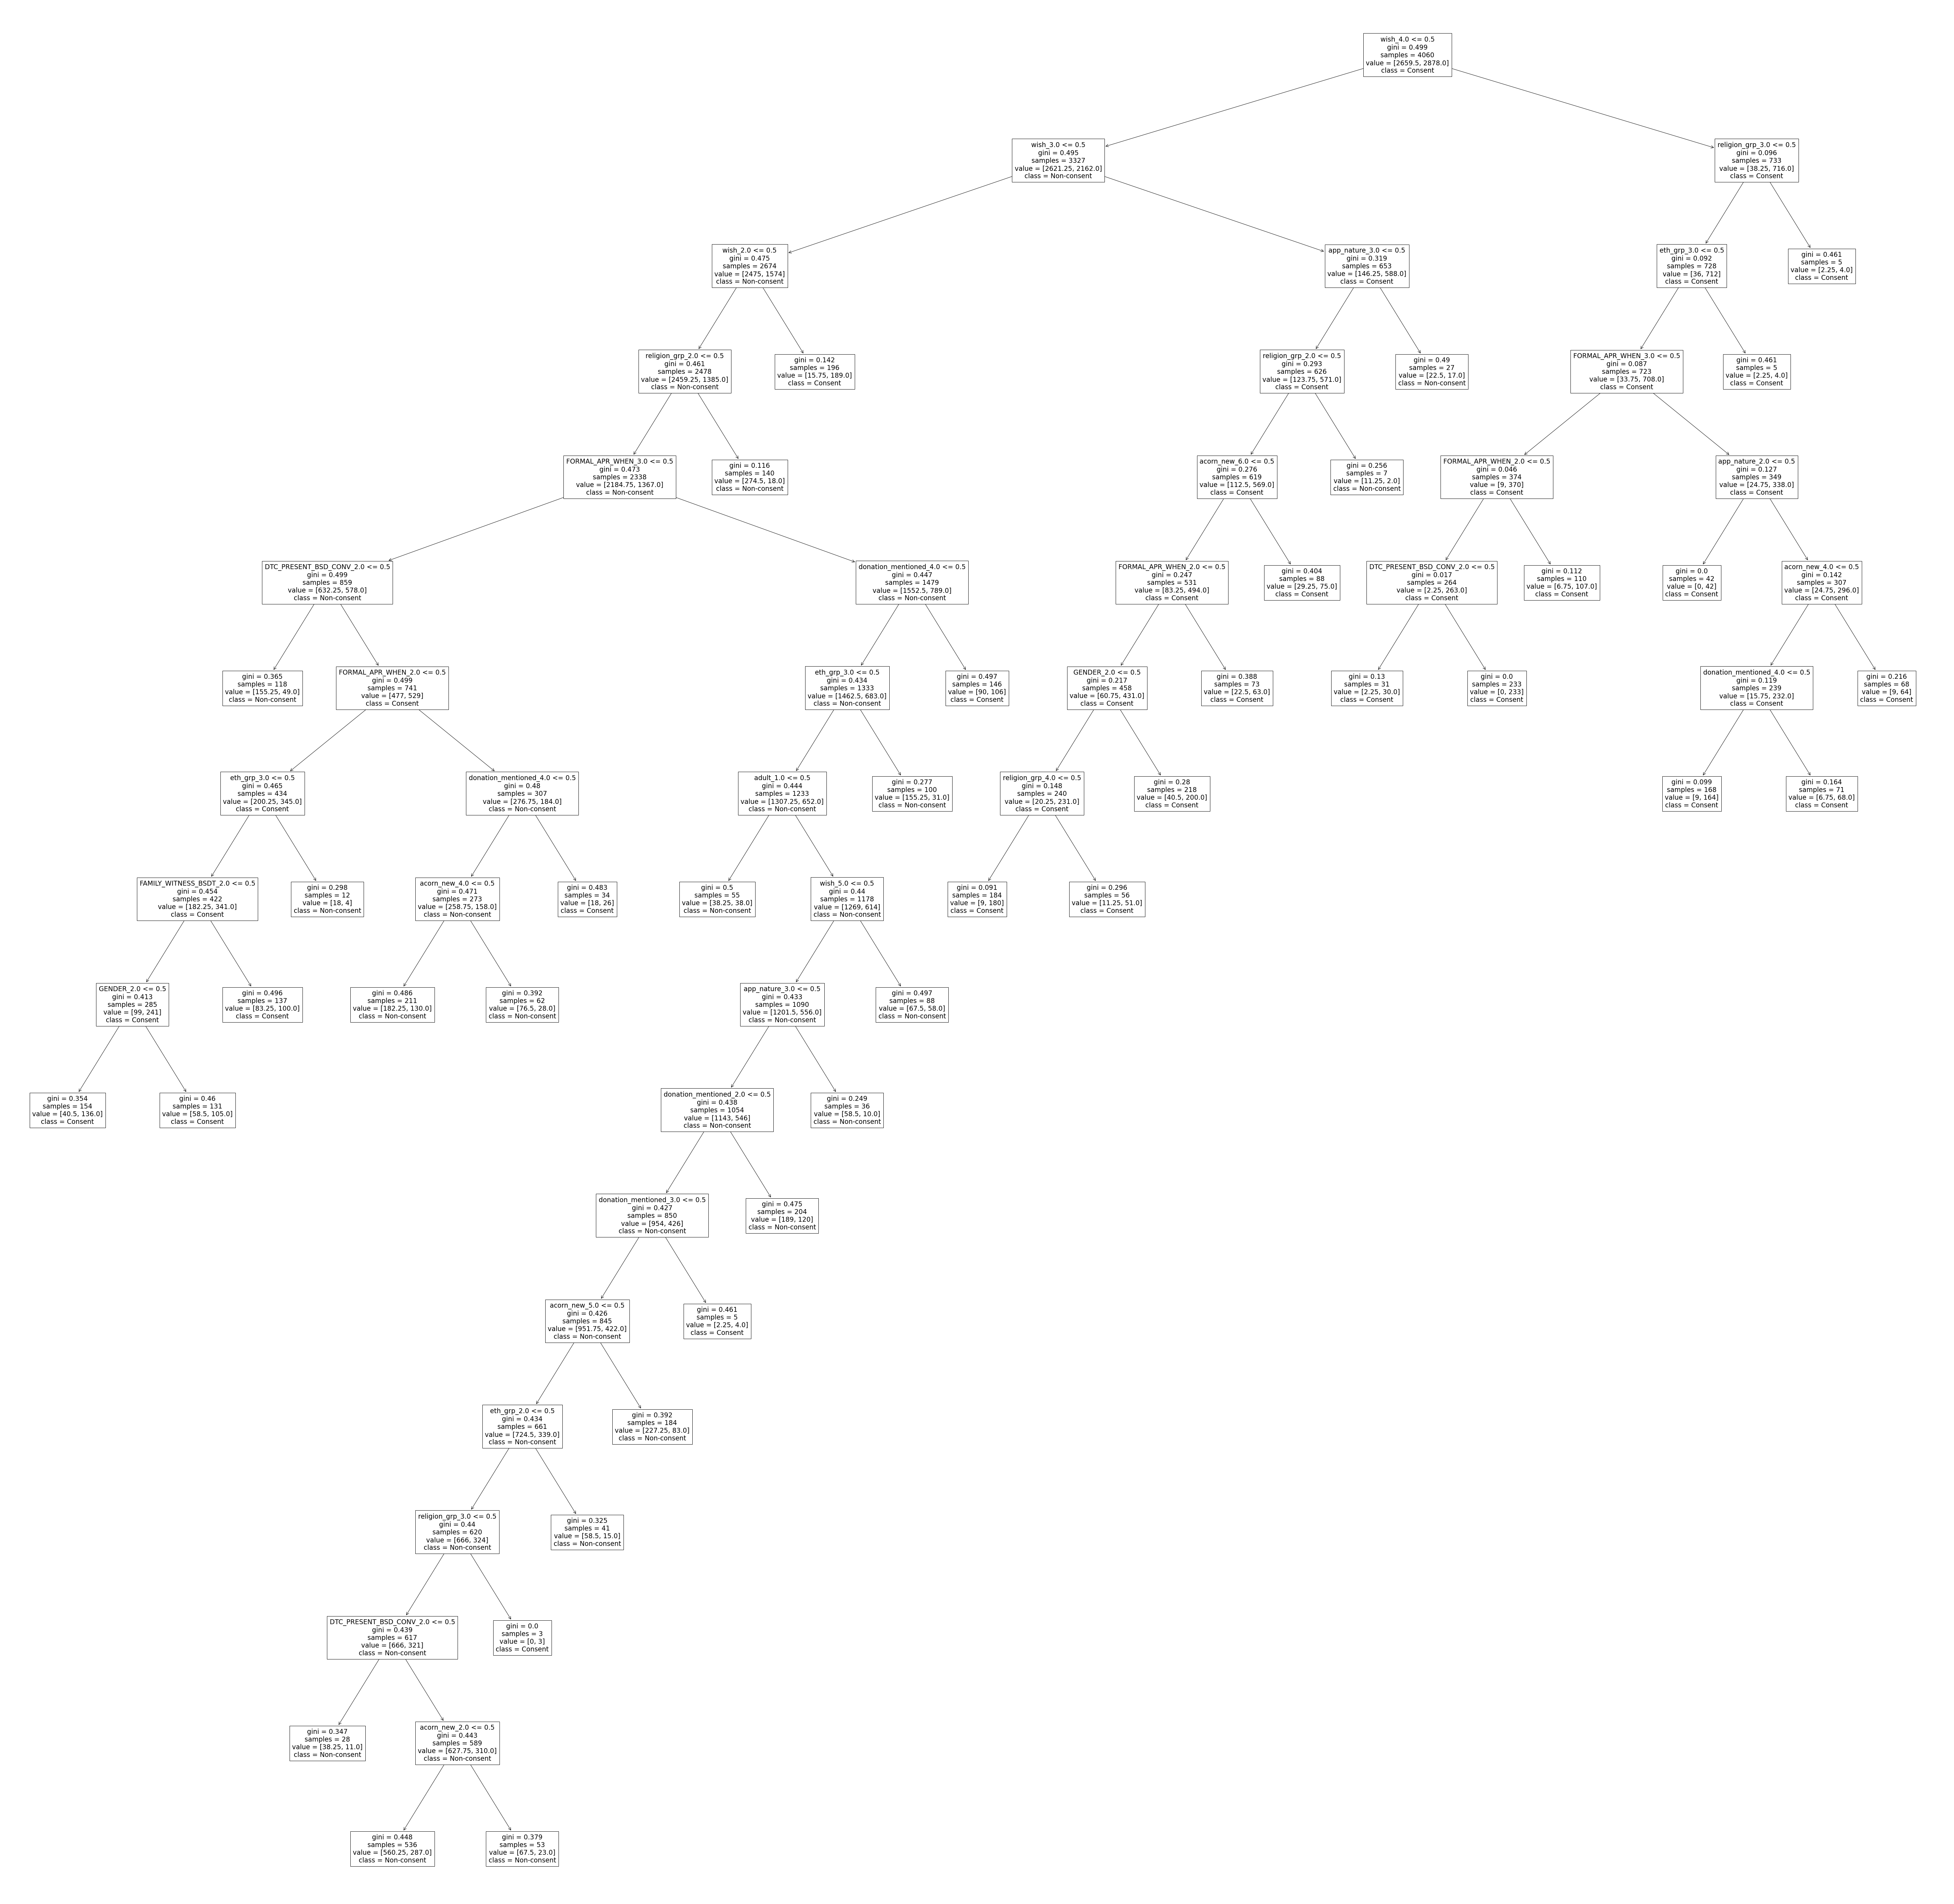

In [5]:
best_tree = DecisionTreeClassifier(**gs_tree_model.best_params_)

best_tree.fit(DBD_X_train,DBD_y_train)

# Plot tree
fig,ax = plt.subplots(1,1,figsize=[100,100])
plot_tree(best_tree,feature_names=dbd_features.columns,class_names=["Non-consent","Consent"])
plt.show()